In [1]:
!pip install bayesian-optimization
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
import numpy as np

SEED=0


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [2]:
data_path = './data/mayhew1.csv'
na_values=['na']
df = pd.read_csv(data_path)
# smiles =  np.loadtxt("./data/smiles.txt", dtype='str')
y=df['odor.class'] # labels, independent variables
y = y.replace(['Odor'], True)
y = y.replace(['Odorless'], False)
assigned = df['dataset.assigned']
df = df.drop(['odor.class.source', 'dataset.assigned', 'odor.class', 
              'transport.ML.odor.probability', 'many.feature.ML.odor.probability'], axis=1)
df = df.set_index('SMILES')
X = df
df

,boiling.point.experimental,boiling.point.estimate.EPISuite,boiling.point.estimate.Banks,boiling.point.estimate.Burnop,boiling.point.best.available,vapor.pressure.experimental,vapor.pressure.best.available,MW,AMW,Sv,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1=CC[C@H](CC1=O)C(=C)C,228.5,224.23,177.316328,211.376140,228.50,0.103000,0.103000,150.24,6.010,14.402,...,0,0,0,0,0,0,0,0,1,0
CC(=O)OC1CC(CC=C1C)C(=C)C,NaN,245.13,220.067558,267.379260,245.13,NaN,0.035300,194.30,6.072,18.171,...,0,0,0,0,1,0,1,0,1,0
CCC(=O)OC1CC(CC=C1C)C(=C)C,NaN,262.43,231.359855,283.769094,262.43,NaN,0.013900,208.33,5.952,19.698,...,0,0,1,0,1,0,1,0,1,0
CC1CC(C)(C)c2c(C1(C)C)cc(c(c2)C(=O)C)C,NaN,331.88,265.346589,354.216698,331.88,0.000512,0.000512,258.44,5.743,25.563,...,0,0,0,0,0,0,0,0,1,0
CC1=CCC(CC1)(O)C(C)C,209.0,211.85,181.799762,205.923187,209.00,NaN,0.042700,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC(=CCC(CO)C(=C)C)C,NaN,221.70,181.799762,195.317301,221.70,NaN,0.019500,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
CC1=CCC(CC1O)C(=C)C,228.0,230.02,179.574801,208.589955,228.00,NaN,0.013200,152.26,5.639,14.929,...,0,0,0,0,0,0,0,0,1,0
C=CC(=O)OCC1CCCO1,NaN,201.85,183.884293,99.383370,201.85,NaN,0.329000,156.20,6.791,13.305,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y

0       True
1       True
2       True
3       True
4       True
        ... 
1919    True
1920    True
1921    True
1922    True
1923    True
Name: odor.class, Length: 1924, dtype: bool

# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [4]:
assigned
train = assigned == 'train'
X_train_t = df.iloc[list(train[train].index)]
y_train_t = y.iloc[list(train[train].index)]
X_train_t

,boiling.point.experimental,boiling.point.estimate.EPISuite,boiling.point.estimate.Banks,boiling.point.estimate.Burnop,boiling.point.best.available,vapor.pressure.experimental,vapor.pressure.best.available,MW,AMW,Sv,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(=O)OC1CC(CC=C1C)C(=C)C,NaN,262.43,231.359855,283.769094,262.43,NaN,0.01390,208.33,5.952,19.698,...,0,0,1,0,1,0,1,0,1,0
CC1=CCC(CC1)(O)C(C)C,209.0,211.85,181.799762,205.923187,209.00,NaN,0.04270,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
CC1=CC[C@](CC1)(O)C(C)C,209.0,211.85,181.799762,205.923187,209.00,NaN,0.04270,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
O=C1C2(C)CCC(C1(C)C)C2,193.0,203.89,179.574801,104.485216,193.00,0.817,0.81700,152.26,5.639,14.929,...,0,0,0,0,0,0,0,0,1,0
OCC1=CC[C@H](CC1)C(=C)C,244.0,241.19,179.574801,208.589955,244.00,NaN,0.00478,152.26,5.639,14.929,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC(=CCC(CO)C(=C)C)C,NaN,221.70,181.799762,195.317301,221.70,NaN,0.01950,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
CC1=CCC(CC1O)C(=C)C,228.0,230.02,179.574801,208.589955,228.00,NaN,0.01320,152.26,5.639,14.929,...,0,0,0,0,0,0,0,0,1,0
C=CC(=O)OCC1CCCO1,NaN,201.85,183.884293,99.383370,201.85,NaN,0.32900,156.20,6.791,13.305,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test = assigned == 'test'
X_test = df.iloc[list(test[test].index)]
y_test = y.iloc[list(test[test].index)]
X_test

,boiling.point.experimental,boiling.point.estimate.EPISuite,boiling.point.estimate.Banks,boiling.point.estimate.Burnop,boiling.point.best.available,vapor.pressure.experimental,vapor.pressure.best.available,MW,AMW,Sv,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(C)C1CCCCC1=O,NaN,218.54,181.799762,205.923187,218.54,NaN,2.120000e-01,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
C(CCC(=O)O)CC(=O)O,337.5,310.29,172.648793,176.064765,337.50,2.270000e-07,2.270000e-07,146.16,7.308,11.493,...,0,0,0,0,0,0,0,0,0,0
CCOC(=O)C1=CC=C(C=C1)N,310.0,279.90,193.292803,253.133872,310.00,NaN,2.580000e-04,165.21,7.183,14.085,...,0,0,0,0,1,0,0,0,1,0
OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@@H]([C@@H]([C@H]3O)O)O[C@@H]3[C@@H](CO)O[C@@H]([C@@H]([C@H]3O)O)O[C@@H]3[C@@H](CO)O[C@@H]([C@@H]([C@H]3O)O)O[C@@H]3[C@H](O[C@H](O[C@@H]4[C@H](O[C@H](O[C@@H]5[C@H](O[C@H](O[C@H]1[C@H]([C@H]2O)O)[C@H](O)[C@H]5O)CO)[C@H](O)[C@H]4O)CO)[C@H](O)[C@H]3O)CO,NaN,1607.62,453.417287,669.161525,1607.62,NaN,0.000000e+00,1135.12,7.722,85.456,...,0,0,0,0,0,0,0,0,0,0
CC1=C(C(CCC1)(C)C)C=CC(=O)C,NaN,262.93,218.405575,267.058434,262.93,5.400000e-02,5.400000e-02,192.33,5.657,18.983,...,0,0,0,0,1,0,1,0,1,0
CC1(C2CCC1(C(=O)C2)C)C,204.0,203.89,179.574801,104.485216,204.00,7.200000e-02,7.200000e-02,152.26,5.639,14.929,...,0,0,0,0,0,0,0,0,1,0
CC/C=C\CCOC(=O)C,NaN,176.55,168.000914,174.345597,176.55,NaN,1.140000e+00,142.22,5.926,13.117,...,0,0,0,0,0,0,0,0,0,0
CC1=C(C(=O)CC1)O,NaN,241.48,127.044885,15.363670,241.48,NaN,8.520000e-04,112.14,7.009,9.537,...,0,0,0,0,0,0,0,0,0,0
CC(=O)OC[C@]1(O[C@H]2O[C@@H](COC(=O)C)[C@@H]([C@H]([C@@H]2OC(=O)C)OC(=O)C)OC(=O)C)O[C@H]([C@@H]([C@H]1OC(=O)C)OC(=O)C)COC(=O)C,NaN,640.99,397.437790,528.426156,640.99,NaN,1.590000e-12,678.66,7.984,51.590,...,0,0,0,0,0,0,0,0,0,0


In [6]:
val = assigned == 'validation'
X_val = df.iloc[list(val[val].index)]
y_val = y.iloc[list(val[val].index)]
X_val

,boiling.point.experimental,boiling.point.estimate.EPISuite,boiling.point.estimate.Banks,boiling.point.estimate.Burnop,boiling.point.best.available,vapor.pressure.experimental,vapor.pressure.best.available,MW,AMW,Sv,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1=CC[C@H](CC1=O)C(=C)C,228.5,224.23,177.316328,211.376140,228.50,1.030000e-01,1.030000e-01,150.24,6.010,14.402,...,0,0,0,0,0,0,0,0,1,0
CC(=O)OC1CC(CC=C1C)C(=C)C,NaN,245.13,220.067558,267.379260,245.13,NaN,3.530000e-02,194.30,6.072,18.171,...,0,0,0,0,1,0,1,0,1,0
CC1CC(C)(C)c2c(C1(C)C)cc(c(c2)C(=O)C)C,NaN,331.88,265.346589,354.216698,331.88,5.120000e-04,5.120000e-04,258.44,5.743,25.563,...,0,0,0,0,0,0,0,0,1,0
C1COCCO1,101.5,102.77,84.854923,79.778891,101.50,3.810000e+01,3.810000e+01,88.12,6.294,7.537,...,0,0,0,0,0,0,0,0,0,0
C1C(SCC(S1)O)O,NaN,285.18,179.574801,NaN,285.18,NaN,6.600000e-05,152.26,9.516,9.911,...,0,0,0,0,0,0,0,0,0,0
CCC1=C(O)C(=O)CC1,NaN,258.96,147.471849,44.898951,258.96,NaN,1.030000e-03,126.17,6.641,11.064,...,0,0,0,0,0,0,0,0,0,0
C([C@@H](C(=O)O)N)C(=O)O,NaN,347.74,156.695493,172.992208,347.74,NaN,2.620000e-07,133.12,8.320,9.461,...,0,0,0,0,0,0,0,0,0,0
CC1(C2CCC1(C(C2)O)C)C,210.0,209.98,181.799762,103.593829,210.00,5.020000e-02,5.020000e-02,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
CC/C=C\CCOC(=O)CC1=CC=CC=C1,NaN,304.70,238.867062,304.305689,304.70,NaN,8.740000e-04,218.32,6.421,20.171,...,0,0,1,0,1,0,1,0,1,0


In [7]:
X_train = X_train_t.append(X_val)
y_train = y_train_t.append(y_val)
X_train

,boiling.point.experimental,boiling.point.estimate.EPISuite,boiling.point.estimate.Banks,boiling.point.estimate.Burnop,boiling.point.best.available,vapor.pressure.experimental,vapor.pressure.best.available,MW,AMW,Sv,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(=O)OC1CC(CC=C1C)C(=C)C,NaN,262.43,231.359855,283.769094,262.43,NaN,1.390000e-02,208.33,5.952,19.698,...,0,0,1,0,1,0,1,0,1,0
CC1=CCC(CC1)(O)C(C)C,209.0,211.85,181.799762,205.923187,209.00,NaN,4.270000e-02,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
CC1=CC[C@](CC1)(O)C(C)C,209.0,211.85,181.799762,205.923187,209.00,NaN,4.270000e-02,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
O=C1C2(C)CCC(C1(C)C)C2,193.0,203.89,179.574801,104.485216,193.00,0.81700,8.170000e-01,152.26,5.639,14.929,...,0,0,0,0,0,0,0,0,1,0
OCC1=CC[C@H](CC1)C(=C)C,244.0,241.19,179.574801,208.589955,244.00,NaN,4.780000e-03,152.26,5.639,14.929,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=CC=C1N)S(=O)(=O)N,NaN,341.95,200.226373,NaN,341.95,NaN,7.320000e-06,172.23,9.065,12.240,...,0,0,0,0,0,0,0,0,1,0
CCCCCCCCN[C@@H]([C@H](c1ccc(cc1)SC(C)C)O)C,NaN,422.62,305.358174,NaN,422.62,NaN,1.780000e-08,337.63,5.821,31.879,...,0,0,0,0,0,0,0,0,0,0
C/C(=C\C)/C(=O)O,185.0,188.47,107.266851,98.504151,185.00,0.13300,1.330000e-01,100.13,6.675,8.537,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y_train

2       True
4       True
5       True
6       True
7       True
       ...  
113    False
114    False
118     True
122    False
124     True
Name: odor.class, Length: 1894, dtype: bool

In [9]:
percentage_odorless = y_train.value_counts()[False]/y_train.shape[0]
percentage_odor = 1 - percentage_odorless
print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 1894
Odor: 1595
Odorless: 299

Total number molecules in test set: 30
Odor: 20
Odorless: 10

Percentage odorless 0.3333333333333333


### Validation set

In [10]:
print("Number of training samples:", len(X_train_t))
print("Number of validation samples:", len(X_val))

Number of training samples: 1864
Number of validation samples: 30


# Test Model 

In [11]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)[:,1]
    
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred_probs))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred))
        
        if hasattr(model, 'feature_importances_') and hasattr(X_test, 'columns'):
            feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
            top_20 = feature_imp.nlargest(20)
            sns.barplot(x=top_20, y=top_20.index)
            plt.xlabel('Descriptor Importance Score')
            plt.ylabel('Descriptor')
            plt.title("Top descriptors")
            plt.show()
        
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probs)  
        
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred_probs) 

def test_model_cross_val(model, y_test, X_test, k=5, verbose=True):
    roc_auc_nans = cross_val_score(model, X_test, y_test, cv=k, scoring='roc_auc')
    print(f"AVERAGE CV={k} ROC_AUC (TEST): {np.mean(roc_auc_nans)}")
    print(f"AVERAGE CV={k} STD (TEST): {np.std(roc_auc_nans)}")

# Handle Non Important Descriptors 

1. Remove values below threshold e.g. 0, any descriptors with 0 importance
2. Get the top N descriptors

In [12]:
def handle_importance(model, X_train, X_test=pd.DataFrame(), threshold=-1, n=-1, verbose=None):
    feature_imp = pd.Series(model.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
    if threshold >= 0:
        feature_imp = feature_imp[feature_imp > threshold]
    
    if n >= 0: 
        feature_imp = feature_imp.nlargest(n)
        
    if verbose: 
        print(feature_imp)
        
    X_train = X_train.loc[:, feature_imp.axes[0].tolist()]
    
    if not X_test.empty:
        X_test = X_test.loc[:, feature_imp.axes[0].tolist()]

    return X_train, X_test, model 

In [13]:
def optimiseImportance(model, X_tr, y_tr, k=5, verbose=True):
    
    imp_params = [
              {"threshold":-1, 'n':5}, 
              {"threshold":-1, 'n':10}, 
              {"threshold":-1, 'n':25}, 
              {"threshold":-1, 'n':50},
              {"threshold":-1, 'n':100}, 
              {"threshold":-1, 'n':200}, 
              {"threshold":-1, 'n':400}, 
              {"threshold":-1, 'n':800},
              {"threshold":-1, 'n':X_tr.shape[1]}]

    print(f"Cross validated importance experiment with k={k}")
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average ROC_AUC', 'Standard Deviation'])

    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}N:{imp_param['n']}".replace("N:-1", '')).replace("Threshold:-1", '')
        
        if verbose:
            print(name)
        
        X_tr_temp , _, _ = handle_importance(model, 
                                            X_tr.copy(), 
                                            threshold=imp_param['threshold'], 
                                            n=imp_param['n'])
                
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average ROC_AUC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar", x="Most important N descriptors", y="Average ROC_AUC", yerr="Standard Deviation", title=f"ROC_AUC after filtering descriptors by importance CV={k}", legend=False)
        
        plt.ylim(0.85,1)
        
    return imp_df

# Handle NaNs


- You cannot have any missing values in the random forest model, you can in XGB
- You cannot have mismatched features between columns in the random forest model
- 3 options 
    1. Remove any columns with missing values 
    2. Remove columns above threshold percentange NaNs e.g. 60% NaNs. 
    3. Remove columns above threshold percentange NaNs e.g. 60% NaNs. Replace columns below threshold with missing values with the mean value.

In [14]:
def handleNaNs(X_tr, X_te, option=1, thresh=0.6): 
    if option == 1:
        nans =  X.columns[X.isna().any()].tolist()
        X_tr.drop(nans, inplace = True, axis=1)
        X_te.drop(nans, inplace = True, axis=1)
    else: 
        nans = X.isna().mean(axis=0)
        # set threshold for percentage nans before we drop 
        X_thresh = nans[nans >= thresh]
        X_tr.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        X_te.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        
        if option == 3: 
            X_tr.fillna(X_train.mean(), inplace=True) 
            X_te.fillna(X_test.mean(), inplace=True)
    
    return X_tr, X_te

In [15]:
def optimiseNaNs(model, X_train, X_test, y_train, y_test, option=2, k=5, verbose=True): 
    print(f"Cross validated missing values experiment with k={k}")
    
    percentages = [x/100 for x in range(0, 100, 10)] 
    nans_df = pd.DataFrame(columns=['Name', 'Average ROC_AUC', 'Standard Deviation'])

    for perc in percentages: 
        name = str(perc)
        if perc == 0:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=1)
        else:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=option, thresh=perc)

        roc_auc_nans = cross_val_score(model, X_train_cv, y_train, cv=k, scoring='roc_auc')
        
        nans_df = nans_df.append({'Name': name, 
                                   'Average ROC_AUC':np.mean(roc_auc_nans), 
                                   'Standard Deviation':np.std(roc_auc_nans)}, 
                                    ignore_index = True)

    if verbose:
        fig = nans_df.plot(kind="bar", x="Name", y="Average ROC_AUC", yerr="Standard Deviation", title=f"ROC_AUC after thresholding descriptors by % NaNs CV={k}", legend=False)
        plt.ylim(0.85,0.98)
        
    return nans_df

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [16]:
# set random state to 0 to allow reproducible results
clf=RandomForestClassifier(random_state=SEED) 

# For readability
y_train_rf = y_train
y_test_rf = y_test
X_train_rf = X_train
X_test_rf = X_test

## Handle NaNs RF

Cross validated missing values experiment with k=5


,Name,Average ROC_AUC,Standard Deviation
0,0.0,0.923656,0.044043
1,0.1,0.919254,0.046958
2,0.2,0.921490,0.045213
3,0.3,0.921490,0.045213
4,0.4,0.917761,0.050319
5,0.5,0.921226,0.047298
6,0.6,0.921226,0.047298
7,0.7,0.921226,0.047298
8,0.8,0.921226,0.047298
9,0.9,0.921226,0.047298


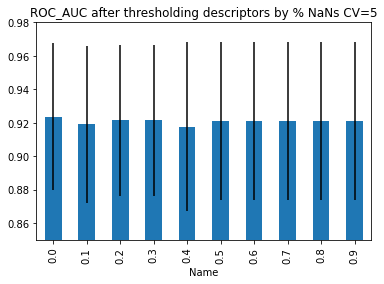

In [17]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(clf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, option=3)

let's just go with removing all the columns with missing values

In [18]:
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)

In [19]:
clf.fit(X_train_rf, y_train_rf)
print("Validation performance of Random Forest after removing all columns with NaNs")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Validation performance of Random Forest after removing all columns with NaNs
AVERAGE CV=5 ROC_AUC (TEST): 0.923655579760197
AVERAGE CV=5 STD (TEST): 0.044042671974349724


## Using Importance to reduce dimensionality

Cross validated importance experiment with k=5
N:5
N:10
N:25
N:50
N:100
N:200
N:400
N:800
N:4866


,Most important N descriptors,Average ROC_AUC,Standard Deviation
0,5.0,0.914705,0.059106
1,10.0,0.921881,0.055872
2,25.0,0.927357,0.051099
3,50.0,0.929760,0.048681
4,100.0,0.934561,0.043885
5,200.0,0.930842,0.046174
6,400.0,0.930431,0.044574
7,800.0,0.928820,0.044700
8,4866.0,0.920574,0.045329


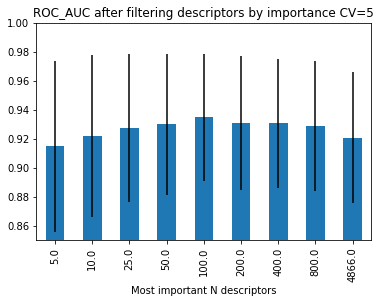

In [20]:
clf.fit(X_train_rf, y_train_rf)
optimiseImportance(clf, X_train_rf, y_train_rf)

### Remove labels 

In [21]:
clf.fit(X_train_rf, y_train_rf)
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=400)

In [22]:
clf.fit(X_train_rf, y_train_rf)
print("Validation set performance of Random Forest after removing labels")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Validation set performance of Random Forest after removing labels
AVERAGE CV=5 ROC_AUC (TEST): 0.9304314329738059
AVERAGE CV=5 STD (TEST): 0.044573573571218245


In [23]:
X_train_rf

,boiling.point.best.available,SM2_B.s.,TPSA.NO.,vapor.pressure.best.available,SpMax3_Bh.s.,P_VSA_p_2,SpAbs_B.s.,SAacc,Psi_i_s,RTs,...,Mor14p,SpMin2_Bh.e.,MPC02,E2m,O.,SpMAD_Dz.p.,RTe,RDF020i,SdsN,Mor27u
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(=O)OC1CC(CC=C1C)C(=C)C,262.43,4.972,26.30,1.390000e-02,4.529,36.145,36.049,36.145,33.667,51.476,...,1.098,1.592,3.045,0.178,5.7,8.745,23.454,5.354,0.0,-0.098
CC1=CCC(CC1)(O)C(C)C,209.00,4.517,20.23,4.270000e-02,4.130,42.683,25.181,42.683,22.750,46.460,...,1.294,1.587,2.833,0.177,3.4,5.209,22.698,4.535,0.0,0.151
CC1=CC[C@](CC1)(O)C(C)C,209.00,4.517,20.23,4.270000e-02,4.130,42.683,25.181,42.683,22.750,46.452,...,1.293,1.587,2.833,0.177,3.4,5.209,22.697,4.519,0.0,0.146
O=C1C2(C)CCC(C1(C)C)C2,193.00,4.647,17.07,8.170000e-01,3.975,25.145,26.169,25.145,23.000,48.600,...,0.949,1.636,3.091,0.326,3.7,4.291,22.825,1.086,0.0,0.269
OCC1=CC[C@H](CC1)C(=C)C,244.00,4.583,20.23,4.780000e-03,4.320,42.683,25.847,42.683,23.667,45.413,...,1.117,1.561,2.708,0.125,3.7,5.544,21.790,7.405,0.0,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=CC=C1N)S(=O)(=O)N,341.95,5.233,86.18,7.320000e-06,5.108,108.502,36.527,108.502,34.250,83.852,...,-0.110,1.461,2.833,0.128,10.5,4.043,16.669,3.012,0.0,0.027
CCCCCCCCN[C@@H]([C@H](c1ccc(cc1)SC(C)C)O)C,422.62,5.071,32.26,1.780000e-08,4.323,60.694,48.018,60.694,44.167,58.565,...,1.239,1.798,3.367,0.234,1.7,12.500,29.067,10.317,0.0,0.504
C/C(=C\C)/C(=O)O,185.00,4.799,37.30,1.330000e-01,4.359,67.828,23.246,67.828,22.333,56.390,...,0.249,1.133,2.079,0.177,13.3,4.187,14.251,2.718,0.0,0.057


## Tuning the hyperparamaters 

In [24]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [25]:
# Use the grid to search for best hyperparameters
# Takes ~ 10 minutes to run 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 50)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 50)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 40, 60, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion 
criterion = ['gini', 'entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap, 
               'criterion': criterion}

# Random search of parameters, using 5 fold cross validation, 
# search across 500 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=clf, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=1, random_state=SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

# Print best paramaters 
print(rf_random.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'n_estimators': 659, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}


In [26]:
rf_random.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 659,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [27]:
tuned_rf= RandomForestClassifier(n_estimators=50,
                                 min_samples_split=20,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=10,
                                 criterion='gini',
                                 bootstrap=False,
                                 random_state=SEED)
tuned_rf=RandomForestClassifier(**rf_random.best_params_,
                                 random_state=SEED)
tuned_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_leaf=4, n_estimators=659, random_state=0)

In [28]:
tuned_rf.fit(X_train_rf, y_train_rf)
print("Final tuned validation set performance of Random Forest")
test_model_cross_val(tuned_rf, y_train_rf, X_train_rf, k=5, verbose=True)

Final tuned validation set performance of Random Forest
AVERAGE CV=5 ROC_AUC (TEST): 0.9346608398420205
AVERAGE CV=5 STD (TEST): 0.04080690965301417


ROC_AUC (TEST): 0.9750000000000001


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       1.00      0.80      0.89        10
        True       0.91      1.00      0.95        20

    accuracy                           0.93        30
   macro avg       0.95      0.90      0.92        30
weighted avg       0.94      0.93      0.93        30



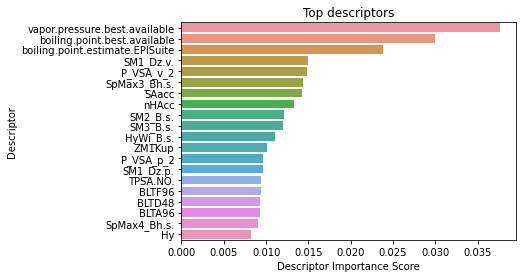

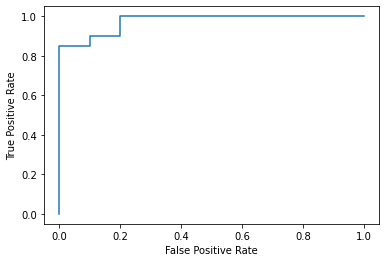

0.9750000000000001

In [29]:
tuned_rf.fit(X_train_rf, y_train_rf)
test_model(tuned_rf, y_test_rf, X_test_rf)

# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [30]:
# for readibility 
y_train_xgb = y_train
y_test_xgb = y_test
X_train_xgb = X_train
X_test_xgb = X_test

## Create model

In [31]:
X_train_xgb.columns = X_train_xgb.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
X_test_xgb.columns = X_test_xgb.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [32]:
# Baseline results
print("Baseline performance of XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Baseline performance of XGBoost
AVERAGE CV=5 ROC_AUC (TEST): 0.9303962772080832
AVERAGE CV=5 STD (TEST): 0.04436666576440176


## Handle NaNs

Cross validated missing values experiment with k=5


,Name,Average ROC_AUC,Standard Deviation
0,0.0,0.930488,0.043904
1,0.1,0.933163,0.040375
2,0.2,0.931055,0.042958
3,0.3,0.931055,0.042958
4,0.4,0.929492,0.045152
5,0.5,0.930396,0.044367
6,0.6,0.930396,0.044367
7,0.7,0.930396,0.044367
8,0.8,0.930396,0.044367
9,0.9,0.930396,0.044367


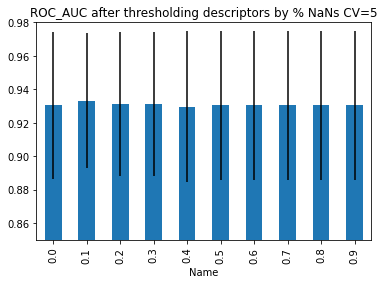

In [33]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=2)

Choose to remove columns with NaNs > 0.7

In [34]:
X_train_xgb, X_test_xgb = handleNaNs(X_train_xgb.copy(), X_test_xgb.copy(), option=2, thresh=0.7)
X_train_t_xgb, X_val_xgb = handleNaNs(X_train_t.copy(), X_val.copy(), option=2, thresh=0.7)

In [35]:
xgb.fit(X_train_xgb, y_train_xgb)
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC (TEST): 0.9303962772080832
AVERAGE CV=5 STD (TEST): 0.04436666576440176


## Importance Experiment XGB

Cross validated importance experiment with k=5
N:5
N:10
N:25
N:50
N:100
N:200
N:400
N:800
N:4870


,Most important N descriptors,Average ROC_AUC,Standard Deviation
0,5.0,0.913944,0.048971
1,10.0,0.917866,0.049842
2,25.0,0.934506,0.042544
3,50.0,0.935908,0.045270
4,100.0,0.938411,0.041870
5,200.0,0.939359,0.041608
6,400.0,0.937127,0.040621
7,800.0,0.936838,0.040131
8,4870.0,0.933064,0.041937


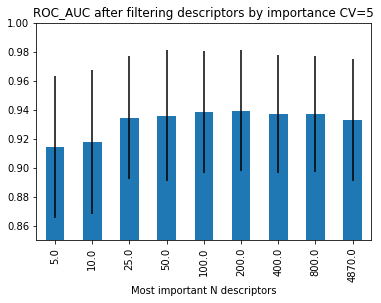

In [36]:
optimiseImportance(xgb, X_train_xgb, y_train_xgb)

In [37]:
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test_xgb, 
                                                threshold=-1, 
                                                n=100)

# Filted importance results
xgb.fit(X_train_xgb, y_train_xgb)
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC (TEST): 0.9384113490250252
AVERAGE CV=5 STD (TEST): 0.04187013469977665


In [38]:
X_train_xgb

,vapor.pressure.best.available,Me,boiling.point.best.available,SpPosA_B.p.,Ho_Dz.v.,SM1_Dz.v.,TDB01m,L2s,E2e,AVS_B.s.,...,GATS8v,MATS3e,RDF010s,IC5,Mor26u,R6s,P1s,JGI4,Mor22p,VE1_B.i.
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(=O)OC1CC(CC=C1C)C(=C)C,1.390000e-02,0.985,262.43,1.228,19.045,-0.587,0.042,2.665,0.386,4.489,...,0.694,-0.088,15.740,4.493,0.567,2.339,0.669,0.058,0.043,3.476
CC1=CCC(CC1)(O)C(C)C,4.270000e-02,0.975,209.00,1.210,13.468,-0.336,0.046,1.425,0.519,4.224,...,0.000,-0.102,17.853,3.883,0.479,1.238,0.709,0.082,0.132,3.111
CC1=CC[C@](CC1)(O)C(C)C,4.270000e-02,0.975,209.00,1.210,13.468,-0.336,0.046,1.425,0.519,4.224,...,0.000,-0.102,17.853,3.883,0.471,1.238,0.709,0.082,0.132,3.111
O=C1C2(C)CCC(C1(C)C)C2,8.170000e-01,0.978,193.00,1.258,12.652,-0.336,0.057,2.020,0.510,4.429,...,0.000,0.040,11.555,3.708,0.358,0.828,0.459,0.067,0.103,2.981
OCC1=CC[C@H](CC1)C(=C)C,4.780000e-03,0.978,244.00,1.228,13.206,-0.336,0.052,1.097,0.408,4.365,...,0.478,0.013,16.997,4.208,0.390,1.085,0.753,0.053,-0.075,3.135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=CC=C1N)S(=O)(=O)N,7.320000e-06,1.031,341.95,1.244,12.033,-0.824,0.181,1.315,0.446,5.590,...,0.000,-0.247,19.261,3.511,-0.308,2.324,0.786,0.053,-0.122,3.058
CCCCCCCCN[C@@H]([C@H](c1ccc(cc1)SC(C)C)O)C,1.780000e-08,0.975,422.62,1.251,29.643,-0.445,0.027,1.726,0.398,4.101,...,1.075,0.085,31.298,5.013,0.673,2.115,0.923,0.035,0.417,3.306
C/C(=C\C)/C(=O)O,1.330000e-01,1.013,185.00,1.176,8.465,-0.587,0.095,1.348,0.521,5.260,...,0.000,-0.034,11.567,2.231,0.247,0.205,0.696,0.000,-0.029,2.459


## Tuning paramaters 

In [39]:
params = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
#    'subsample': (0.7, 1.0),  # Change for big datasets
    'colsample_bytree': (0.7, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5), 
    'scale_pos_weight': (1, 2.5)
    }

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        colsample_bytree,
                        gamma, 
                        scale_pos_weight):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    xgb_temp = XGBClassifier(
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        scale_pos_weight=scale_pos_weight,
        seed=SEED)
    
    # calculate CV=5 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(xgb_temp, X_train_xgb, y_train_xgb, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=xgboost_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | scale_... |
-------------------------------------------------------------------------------------------------
| 1         | 0.9303    | 0.8646    | 3.576     | 0.6067    | 6.814     | 481.3     | 1.969     |
| 2         | 0.9248    | 0.8313    | 4.459     | 0.964     | 5.684     | 812.6     | 1.793     |
| 3         | 0.9361    | 0.8704    | 4.628     | 0.08033   | 3.61      | 118.2     | 2.249     |
| 4         | 0.9223    | 0.9334    | 4.35      | 0.9788    | 8.594     | 515.3     | 2.171     |
| 5         | 0.9352    | 0.7355    | 3.2       | 0.1519    | 9.613     | 569.7     | 1.622     |
| 6         | 0.9175    | 0.9324    | 3.685     | 0.8353    | 4.856     | 118.5     | 1.939     |
| 7         | 0.9385    | 0.7767    | 2.654     | 0.1422    | 9.874     | 855.2     | 1.472     |
| 8         | 0.9275    | 0.8818    | 0.06451   | 0.6193    | 5.891     | 992.5     | 1.636     |
| 9         | 0.9404

| 51        | 0.9261    | 0.7172    | 1.829     | 0.5703    | 9.54      | 855.3     | 1.277     |
| 52        | 0.9325    | 0.9343    | 4.225     | 0.3136    | 5.773     | 467.6     | 2.073     |
| 53        | 0.9204    | 0.7903    | 3.637     | 0.8975    | 5.197     | 742.4     | 1.427     |
| 54        | 0.9305    | 0.8749    | 2.613     | 0.6436    | 8.218     | 841.9     | 1.667     |
| 55        | 0.931     | 0.8475    | 4.32      | 0.452     | 7.116     | 655.7     | 2.038     |


In [40]:
params_tuned_xgb = optimizer.max['params']
params_tuned_xgb['max_depth'] = int(params_tuned_xgb['max_depth'])
params_tuned_xgb['n_estimators'] = int(params_tuned_xgb['n_estimators'])
print(params_tuned_xgb)

tuned_xgb = XGBClassifier(**params_tuned_xgb, seed=SEED)
tuned_xgb.fit(X_train_xgb, y_train_xgb)

test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

{'colsample_bytree': 0.9455616778624734, 'gamma': 1.561744075279029, 'learning_rate': 0.059111859022187276, 'max_depth': 9, 'n_estimators': 280, 'scale_pos_weight': 1.9026517248188508}
AVERAGE CV=5 ROC_AUC (TEST): 0.9406503373890865
AVERAGE CV=5 STD (TEST): 0.040699066124903524


### Final tuned paramaters


In [41]:
params = {'colsample_bytree': 0.8399023550780697, 'gamma': 0.338189317375458, 'learning_rate': 0.1742061546805264, 'max_depth': 8, 'n_estimators': 643, 'scale_pos_weight': 1.3398087284581912}
params=params_tuned_xgb
tuned_xgb = XGBClassifier(**params,
                          seed=SEED,  
                          n_jobs = -1)

ROC_AUC (TEST): 0.97


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90        10
        True       0.95      0.95      0.95        20

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



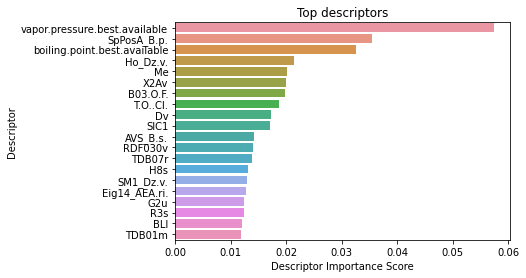

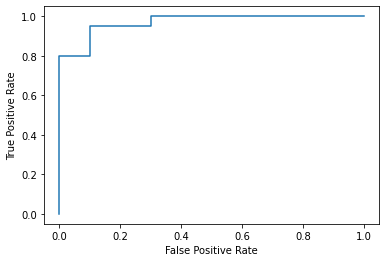

0.97

In [42]:
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

# Keras

https://www.pluralsight.com/guides/classification-keras

In [43]:
!pip install keras
!pip install scikeras

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# for readibility 
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()

tf.random.set_seed(SEED)


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1894 entries, CCC(=O)OC1CC(CC=C1C)C(=C)C to C(COCCOCCO)O
Columns: 4870 entries, boiling.point.experimental to Infective.50
dtypes: float64(2640), int64(2230)
memory usage: 70.4+ MB


## Preprocessing

### Handle NaNs 
- You can't have missing values in a Neural Network, so we choose to remove all columns with them (for now)

In [45]:
X_train_nn, X_test_nn = handleNaNs(X_train.copy(), X_test.copy(), option=1)

## Prepare a validation set
- Stratified 

In [46]:
X_train_t_nn, X_val_nn, y_train_t_nn, y_val_nn = X_train_t.copy(), X_val.copy(), y_train_t.copy(), y_val.copy()

In [47]:
X_train_t_nn, X_val_nn = handleNaNs(X_train_t_nn.copy(), X_val_nn.copy(), option=1)

### Standardization 

Standardization is an effective data preparation scheme for tabular data when building neural network models. This is where the data is rescaled such that the mean value for each attribute is 0, and the standard deviation is 1. This preserves Gaussian and Gaussian-like distributions while normalizing the central tendencies for each attribute.

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

- not necessary for tree based algorithms because they are fairly insensitive to the scale of features "The decision tree splits a node on a feature that increases the homogeneity of the node. This split on a feature is not influenced by other features. Hence, there is virtually no effect of the remaining features on the split. This is what makes them invariant to the scale of the features." https://www.atoti.io/articles/when-to-perform-a-feature-scaling/#:~:text=In%20Neural%20Networks%20algorithm%20that,an%20essential%20pre%2Dprocessing%20step.

- Note: The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.

In [48]:
scaler = StandardScaler()
X_train_t_nn = scaler.fit_transform(X_train_t_nn) 
X_val_nn = scaler.transform(X_val_nn) 

scaler2 = StandardScaler()
X_train_nn = scaler2.fit_transform(X_train_nn) 
X_test_nn = scaler2.transform(X_test_nn) 

### Encode class values as integers

Use adam optimizer so we don't have to specify learning rate, as is the case with gradient descent, and optimise for it

In [49]:
encoder = LabelEncoder()
encoder.fit(y_train_nn)
y_train_nn = encoder.transform(y_train_nn)
y_train_t_nn = encoder.transform(y_train_t_nn)
y_test_nn = encoder.transform(y_test_nn)
y_val_nn = encoder.transform(y_val_nn)

## Metrics

In [50]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc', curve='ROC'),
]

## Test model - Keras

In [51]:
def test_model_keras(model, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn): 
    # Plot training and validation auc 

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model roc_auc')
    plt.ylabel('ROC_AUC')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # Plot training and validation ROC curve

    y_pred_keras = model.predict(X_val_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val_nn, y_pred_keras)
    auc_v_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)

    y_pred_t_keras = model.predict(X_train_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_nn, y_pred_t_keras)
    auc_t_keras = metrics.roc_auc_score(y_train_nn, y_pred_t_keras)

    plt.plot(fpr_keras, tpr_keras)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(['', 'Validation (area = {:.3f})'.format(auc_v_keras), 'Training (area = {:.3f})'.format(auc_t_keras)], loc='best')
    plt.show()
    plt.show()


## Baseline Single Layer model
- Overfitting quite a bit, you can see it when you compare the validation set auc and the auc for the training set 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4867)              23687689  
                                                                 
 dense_1 (Dense)             (None, 1)                 4868      
                                                                 
Total params: 23,692,557
Trainable params: 23,692,557
Non-trainable params: 0
_________________________________________________________________


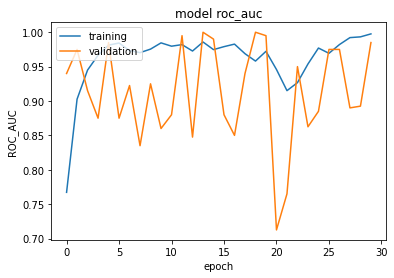

59/59 [==============================] - 1s 10ms/step


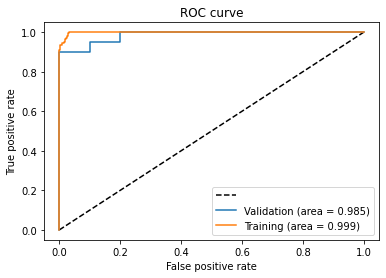

In [52]:
model = keras.Sequential()
model.add(keras.layers.Dense(X_train_nn.shape[-1]+1, activation="relu", input_shape=(X_train_nn.shape[-1],)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30, 
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

## Feature selection on multilayer model

Using the set of the top 100 descriptors from RF and XGB, filter the dataset by these descriptors, and then measure validation accuracy

Choose f_classif method of feature selection, with 100 features.
### Tune and Train multilayer model

In [53]:
def model_builder_3(hp):

    model = keras.Sequential()
    model.add(Dense(100, input_shape=(100,), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

In [54]:
import sklearn.feature_selection as fs
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train_nn)
X_train_nn = constant_filter.transform(X_train_nn)
X_test_nn = constant_filter.transform(X_test_nn)
X_val_nn = constant_filter.transform(X_val_nn)
X_train_t_nn = constant_filter.transform(X_train_t_nn)


    
bk = fs.SelectKBest(fs.f_classif, k=100)
bk.fit(X_train_nn, y_train_nn)
X_train_nn = bk.transform(X_train_nn)

In [55]:
X_val_nn = bk.transform(X_val_nn)

In [56]:
X_test_nn = bk.transform(X_test_nn)

In [57]:
X_train_t_nn = bk.transform(X_train_t_nn)

In [58]:
print(X_val_nn.shape)
tuner = kt.Hyperband(model_builder_3,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir",
                     project_name="odor",
                     overwrite=True,)
                     
tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=30,
             validation_data=(X_val_nn, y_val_nn),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

Trial 30 Complete [00h 00m 02s]
val_auc: 0.9800000190734863

Best val_auc So Far: 1.0
Total elapsed time: 00h 01m 11s
INFO:tensorflow:Oracle triggered exit


In [59]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
 The optimal number of units in the first densely-connected
layer is 522 
 The optimal number of units in the second densely-connected
layer is 352 
 The optimal number of dropouts in the first densely-connected
layer is 0.15000000000000002.
 The optimal learning 
rate is  0.0001



In [60]:
model4 = tuner.hypermodel.build(best_hps)
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 522)               52722     
                                                                 
 dropout_1 (Dropout)         (None, 522)               0         
                                                                 
 dense_6 (Dense)             (None, 352)               184096    
                                                                 
 dense_7 (Dense)             (None, 1)                 353       
                                                                 
Total params: 247,271
Trainable params: 247,271
Non-trainable params: 0
_________________________________________________________________


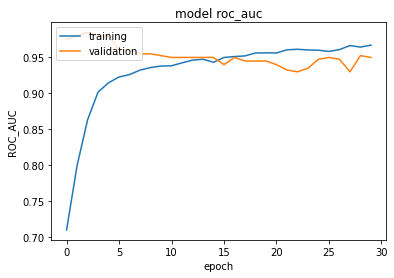

60/60 [==============================] - 0s 1ms/step


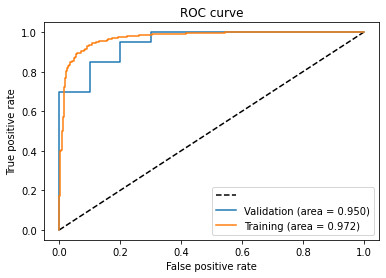

In [61]:
history = model4.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30,
                      batch_size=64,
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

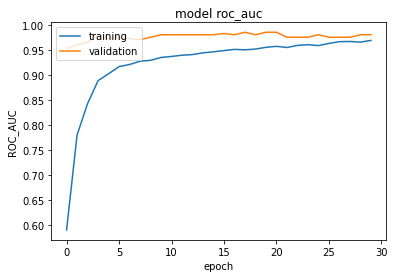

60/60 [==============================] - 0s 1ms/step


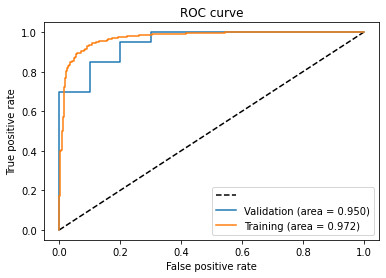

In [62]:
model_final = tuner.hypermodel.build(best_hps)

# Build the final model with all the training data with the optimal hyperparameters 
history = model_final.fit(X_train_nn, 
                      y_train_nn, 
                      epochs=30,
                      batch_size=64,
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

## Evaluate model on test data

1/1 [==============================] - 0s 42ms/step


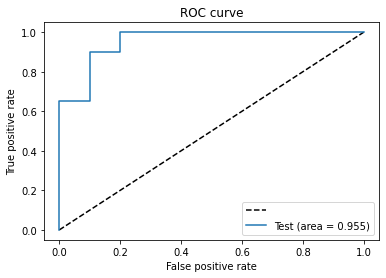

In [63]:
y_pred_t_keras = model_final.predict(X_test_nn).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_nn, y_pred_t_keras)
auc_t_keras = metrics.roc_auc_score(y_test_nn, y_pred_t_keras)
auc_t_keras

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(['', 'Test (area = {:.3f})'.format(auc_t_keras)], loc='best')
plt.show()
plt.show()